In [2]:
import sys
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("../file_loader")
sys.path.append("../preprocessing-block")

import ecg_file_loader
from ecg_file_loader import ECGFileLoader

import rpeaks_finder
from rpeaks_finder import *


reload(ecg_file_loader)
reload(rpeaks_finder)


<module 'rpeaks_finder' from '/Users/pietrosaveri/Desktop/Pietro/•StartUps/Seizury/• src_blocks/check_codes/../preprocessing-block/rpeaks_finder.py'>

### Pan with neurokit

In [11]:
import neurokit2 as nk
import mne

# ecg_signal
ecg_signal = "/Users/pietrosaveri/Desktop/Pietro/•StartUps/Seizury/scr/Open_Neuro/data/sub-001/ses-01/ecg/sub-001_ses-01_task-szMonitoring_run-01_ecg.edf"

raw = mne.io.read_raw_edf(ecg_signal, preload=True, verbose=False)

# Get the ECG data as a numpy array (channels x samples)
ecg_data = raw.get_data()

# If there is only one channel, flatten to 1D
ecg_1d = ecg_data[0]
print(ecg_1d.shape)

sampling_rate = raw.info['sfreq']
print(f"Sampling rate: {sampling_rate} Hz")

#signals, info = nk.ecg_process(ecg_1d, sampling_rate=sampling_rate, method="pantompkins1985")
ecg_1d_clean = nk.ecg_clean(ecg_1d, sampling_rate=sampling_rate, method="pantompkins1985")
signals, info = nk.ecg_peaks(ecg_1d_clean, sampling_rate=sampling_rate, method="pantompkins1985")


rpeaks = info["ECG_R_Peaks"]
print(rpeaks)

(16721664,)
Sampling rate: 256.0 Hz
[      77      160      240 ... 16720448 16720685 16720898]


#### Plotting with r peaks

/Users/pietrosaveri/Desktop/Pietro/•StartUps/Seizury/• src_blocks/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



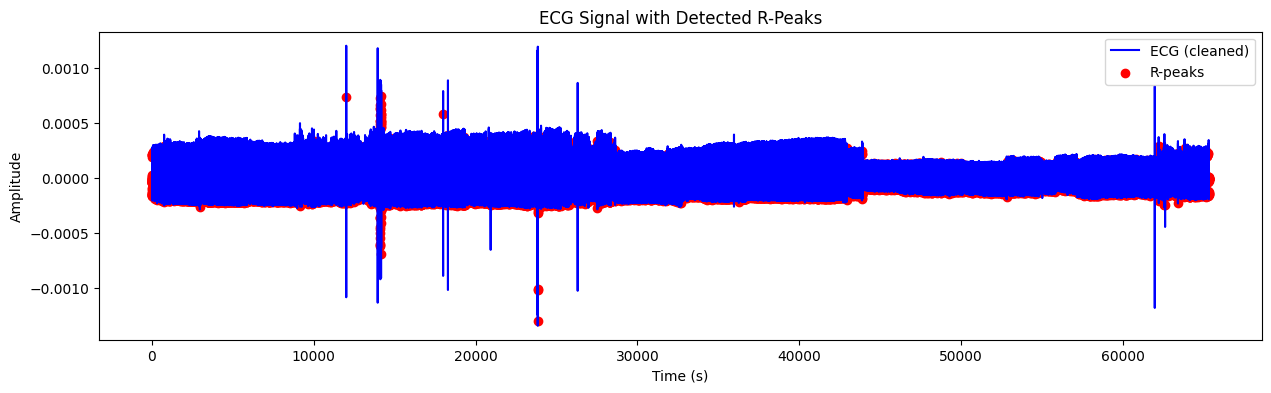

In [22]:
time = np.arange(len(ecg_1d)) / sampling_rate

# Plot ECG and R-peaks
plt.figure(figsize=(15, 4))
plt.plot(time, ecg_1d_clean, label='ECG (cleaned)', color='blue')
plt.scatter(time[rpeaks], ecg_1d_clean[rpeaks], color='red', label='R-peaks', marker='o')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ECG Signal with Detected R-Peaks")
plt.legend()
plt.show()

#### Tachogrma

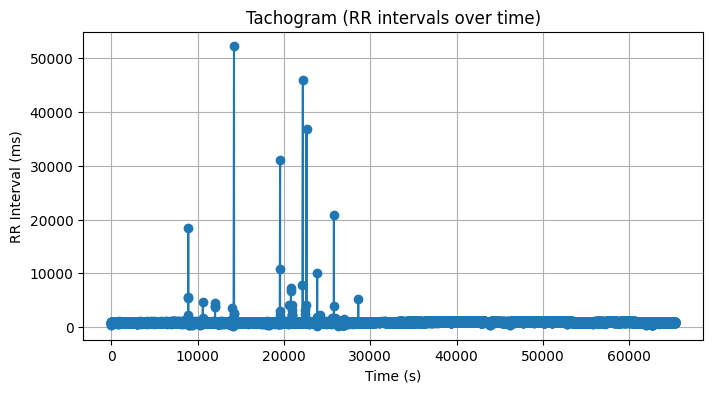

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk


rpeaks_times = rpeaks / sampling_rate  # seconds

# RR intervals = time differences between consecutive R-peaks
rr_intervals_s = np.diff(rpeaks_times)     # in seconds
rr_intervals_ms = rr_intervals_s * 1000    # convert to milliseconds

time_axis = rpeaks_times[1:]

mask = time_axis <= 10
time_10s = time_axis[mask]
rr_10s = rr_intervals_ms[mask]

plt.figure(figsize=(8, 4))
plt.plot(time_axis, rr_intervals_ms, marker='o', linestyle='-')

plt.title("Tachogram (RR intervals over time)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.grid(True)
plt.show()


### Pan with ECGDetectors

In [24]:
import neurokit2 as nk
import mne
from ecgdetectors import Detectors

# ecg_signal
ecg_signal = "/Users/pietrosaveri/Desktop/Pietro/•StartUps/Seizury/scr/Open_Neuro/data/sub-001/ses-01/ecg/sub-001_ses-01_task-szMonitoring_run-01_ecg.edf"

raw = mne.io.read_raw_edf(ecg_signal, preload=True, verbose=False)

# Get the ECG data as a numpy array (channels x samples)
ecg_data = raw.get_data()

# If there is only one channel, flatten to 1D
ecg_1d = ecg_data[0]
print(ecg_1d.shape)

sampling_rate = raw.info['sfreq']
print(f"Sampling rate: {sampling_rate} Hz")


detectors = Detectors(sampling_rate)
rpeaks = np.array(detectors.pan_tompkins_detector(ecg_1d))

print(rpeaks)

(16721664,)
Sampling rate: 256.0 Hz
[      82      159      251 ... 16720468 16720690 16720902]


##### Plot using the rpeaks

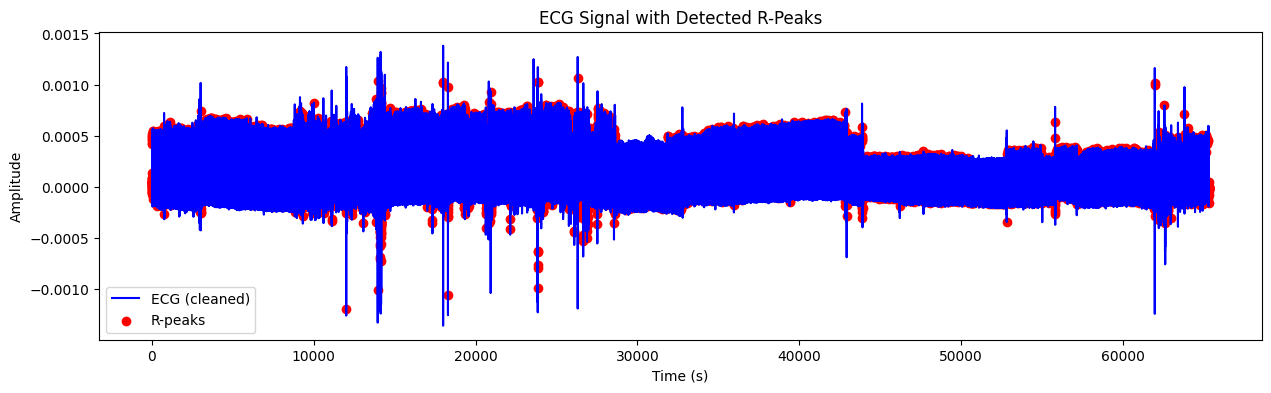

In [25]:
# Create time axis in seconds
time = np.arange(len(ecg_1d)) / sampling_rate

# Plot ECG and R-peaks
plt.figure(figsize=(15, 4))
plt.plot(time, ecg_1d, label='ECG (cleaned)', color='blue')
plt.scatter(time[rpeaks], ecg_1d[rpeaks], color='red', label='R-peaks', marker='o')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ECG Signal with Detected R-Peaks")
plt.legend()
plt.show()

#### Tachogram

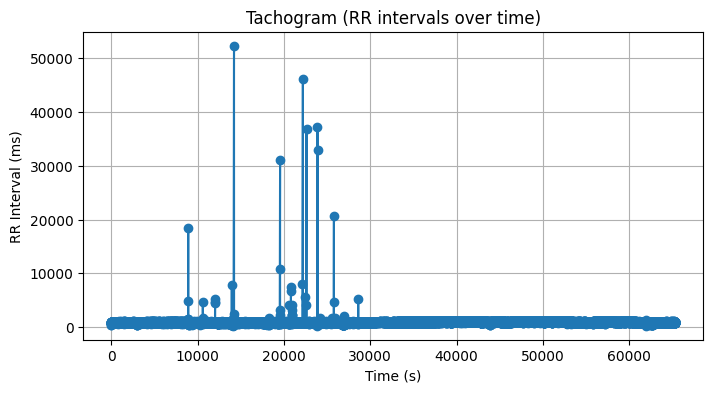

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk

rpeaks_times = rpeaks / sampling_rate  # seconds

# RR intervals = time differences between consecutive R-peaks
rr_intervals_s = np.diff(rpeaks_times)     # in seconds
rr_intervals_ms = rr_intervals_s * 1000    # convert to milliseconds

time_axis = rpeaks_times[1:]

mask = time_axis <=60000
time_10s = time_axis[mask]
rr_10s = rr_intervals_ms[mask]

plt.figure(figsize=(8, 4))
plt.plot(time_axis, rr_intervals_ms, marker='o', linestyle='-')

plt.title("Tachogram (RR intervals over time)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.grid(True)
plt.show()

### Using the biosppy 

In [ ]:
import biosppy
import numpy as np
import mne
from biosppy.signals import ecg


ecg_signal = "/Users/pietrosaveri/Desktop/Pietro/•StartUps/Seizury/scr/Open_Neuro/data/sub-001/ses-01/ecg/sub-001_ses-01_task-szMonitoring_run-01_ecg.edf"

raw = mne.io.read_raw_edf(ecg_signal, preload=True, verbose=False)
ecg_data = raw.get_data()
ecg_1d = ecg_data[0]  # Assuming single channel
sampling_rate = raw.info['sfreq']

print(f"Signal shape: {ecg_1d.shape}")
print(f"Sampling rate: {sampling_rate} Hz")


# Process the ECG signal
out = ecg.engzee_segmenter(signal=ecg_1d, sampling_rate=sampling_rate) #2.28s
#out = ecg.hamilton_segmenter(signal=ecg_1d, sampling_rate=sampling_rate)
rpeaks = out['rpeaks']

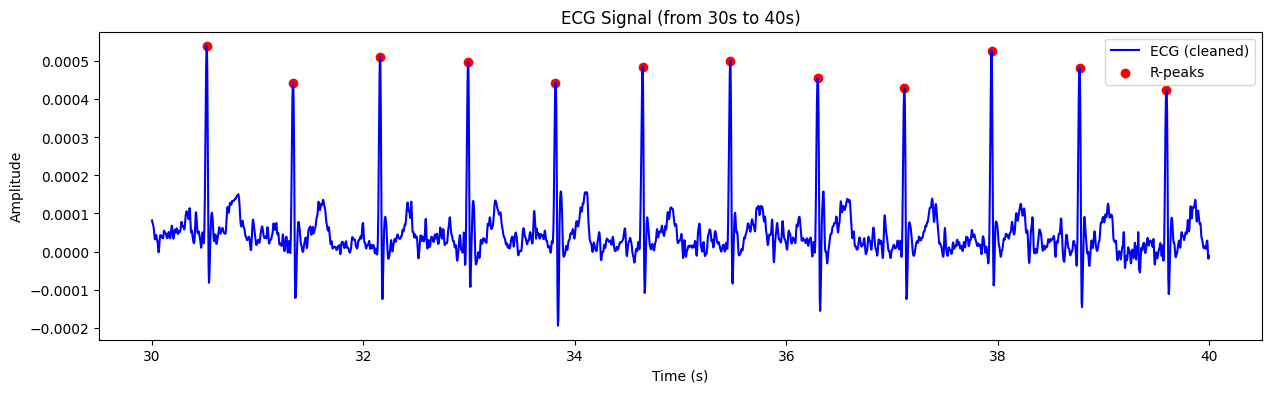

In [72]:
# Choose a 10s window (e.g. 30–40s)
start_time = 30
duration = 10
end_time = start_time + duration

# Convert to samples
start_idx = int(start_time * sampling_rate)
end_idx = int(end_time * sampling_rate)

# Slice data
time_window = time[start_idx:end_idx]
ecg_window = ecg_1d[start_idx:end_idx]

# Filter R-peaks
rpeaks_window = rpeaks[(rpeaks >= start_idx) & (rpeaks < end_idx)]

# Plot
plt.figure(figsize=(15, 4))
plt.plot(time_window, ecg_window, label='ECG (cleaned)', color='blue')
plt.scatter(time[rpeaks_window], ecg_1d[rpeaks_window], color='red', label='R-peaks', marker='o')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"ECG Signal (from {start_time}s to {end_time}s)")
plt.legend()
plt.show()


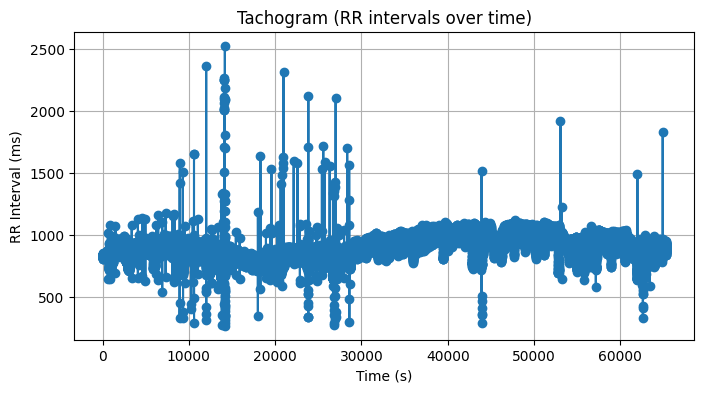

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk

rpeaks_times = rpeaks / sampling_rate  # seconds

# RR intervals = time differences between consecutive R-peaks
rr_intervals_s = np.diff(rpeaks_times)     # in seconds
rr_intervals_ms = rr_intervals_s * 1000    # convert to milliseconds

time_axis = rpeaks_times[1:]

mask = time_axis <=60000
time_10s = time_axis[mask]
rr_10s = rr_intervals_ms[mask]

plt.figure(figsize=(8, 4))
plt.plot(time_axis, rr_intervals_ms, marker='o', linestyle='-')

plt.title("Tachogram (RR intervals over time)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.grid(True)
plt.show()

# Using the `pantompkins.py` file

In [121]:
loader = ECGFileLoader(use_s3=False)

In [ ]:
processed_data = process_all_patients_rpeaks(loader, ['sub-036'], method='neurokit')

In [98]:
print(type(processed_data))                      # should be dict
print(type(processed_data['sub-036']))           # should be list
print(type(processed_data['sub-036'][0]))        # should be dict
print(processed_data['sub-036'][0].keys())       # shows the available data fields

print(" ")

<class 'dict'>
<class 'list'>
<class 'dict'>
dict_keys(['patient_id', 'run_number', 'seizure_events', 'annotations', 'ecg_signal', 'sampling_rate', 'duration_seconds', 'rpeaks', 'rpeaks_times', 'rr_intervals_ms', 'num_beats', 'processing_method'])
 


`ecg_raw`: The original MNE Raw object for the ECG run (full metadata, channels, etc.).

`ecg_signal`: The raw ECG signal as a 1D NumPy array (just the signal values, usually in volts).

`pantompkins_signals`: Output from NeuroKit2’s ecg_peaks function; a DataFrame with columns like 'ECG_R_Peaks' (binary vector marking R-peak locations).

`pantompkins_info`: Dictionary from NeuroKit2 with detailed info, including the 'ECG_R_Peaks' array (indices of R-peaks).

`rpeaks`: The sample indices of detected R-peaks (same as pantompkins_info["ECG_R_Peaks"]).

`rpeaks_times`: The times (in seconds) of each R-peak (i.e., rpeaks / sampling_rate).

`rr_intervals_ms`: The RR intervals (in milliseconds) between consecutive R-peaks.

In [99]:
processed_data['sub-036'][0]['rpeaks']

array([     184,      357,      532, ..., 18522789, 18522897, 18522979],
      shape=(85145,))

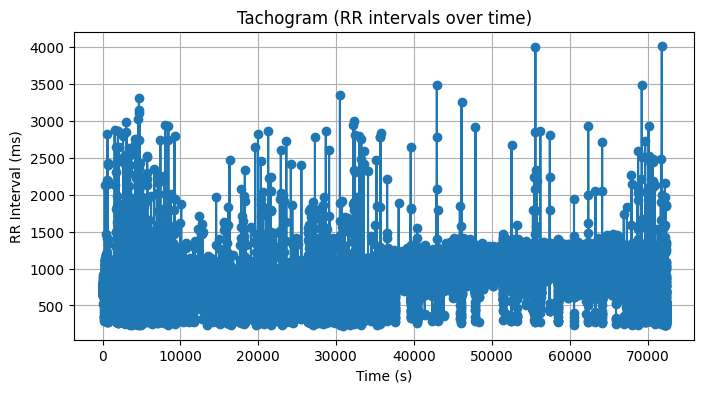

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk


rr_intervals_ms = processed_data['sub-036'][0]['rr_intervals_ms']
time_axis = processed_data['sub-036'][0]['rpeaks_times'][1:]

mask = time_axis <=60000
time_10s = time_axis[mask]
rr_10s = rr_intervals_ms[mask]

plt.figure(figsize=(8, 4))
plt.plot(time_axis, rr_intervals_ms, marker='o', linestyle='-')

plt.title("Tachogram (RR intervals over time)")
plt.xlabel("Time (s)")
plt.ylabel("RR Interval (ms)")
plt.grid(True)
plt.show()

### Plotting

In [103]:
def plot_ecg_with_rpeaks(processed_run_data, time_window_seconds=30, start_time=0):

    # Extract data
    ecg_signal = processed_run_data['sub-036'][0]['ecg_signal']
    rpeaks = processed_run_data['sub-036'][0]['rpeaks']
    sampling_rate = processed_run_data['sub-036'][0]['sampling_rate']
    seizure_events = processed_run_data['sub-036'][0]['seizure_events']
    
    # Calculate sample indices for the time window
    start_sample = int(start_time * sampling_rate)
    end_sample = int((start_time + time_window_seconds) * sampling_rate)
    end_sample = min(end_sample, len(ecg_signal))
    
    # Extract signal segment
    time_axis = np.arange(start_sample, end_sample) / sampling_rate
    ecg_segment = ecg_signal[start_sample:end_sample]
    
    # Filter R-peaks within the time window
    rpeaks_in_window = rpeaks[(rpeaks >= start_sample) & (rpeaks < end_sample)]
    rpeaks_times = rpeaks_in_window / sampling_rate
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    # Plot ECG signal
    plt.plot(time_axis, ecg_segment * 1e6, 'b-', linewidth=0.8, label='ECG Signal')
    
    # Plot R-peaks
    if len(rpeaks_in_window) > 0:
        rpeak_values = ecg_signal[rpeaks_in_window] * 1e6
        plt.scatter(rpeaks_times, rpeak_values, color='red', s=50, zorder=5, label=f'R-peaks ({len(rpeaks_in_window)})')
    
    # Mark seizure events if any overlap with the time window
    for i, seizure in enumerate(seizure_events):
        seizure_start = seizure['onset_time']
        seizure_end = seizure_start + seizure['duration']
        
        # Check if seizure overlaps with our time window
        if seizure_start < (start_time + time_window_seconds) and seizure_end > start_time:
            plt.axvspan(max(seizure_start, start_time), 
                       min(seizure_end, start_time + time_window_seconds), 
                       alpha=0.3, color='orange', 
                       label=f'Seizure {i+1}' if i == 0 else "")
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('ECG Amplitude (μV)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Statistics for this window:")
    print(f"  R-peaks detected: {len(rpeaks_in_window)}")
    if len(rpeaks_in_window) > 1:
        window_rr = np.diff(rpeaks_in_window) / sampling_rate * 1000
        window_hr = 60000 / np.mean(window_rr)
        print(f"  Average RR interval: {np.mean(window_rr):.1f} ms")
        print(f"  Average heart rate in window: {window_hr:.1f} bpm")

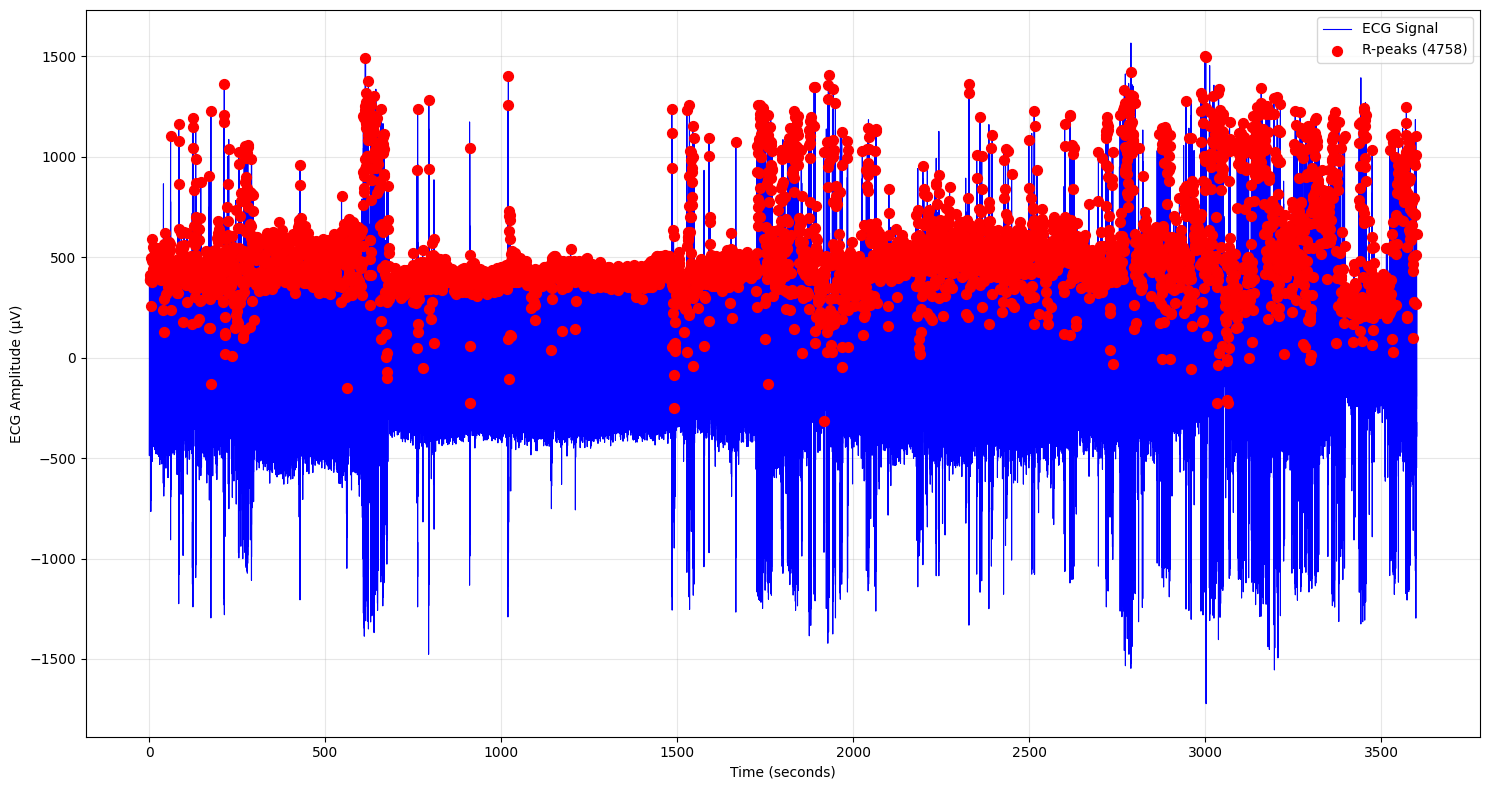

Statistics for this window:
  R-peaks detected: 4758
  Average RR interval: 756.6 ms
  Average heart rate in window: 79.3 bpm

Plotting around first seizure at 40971.0s:


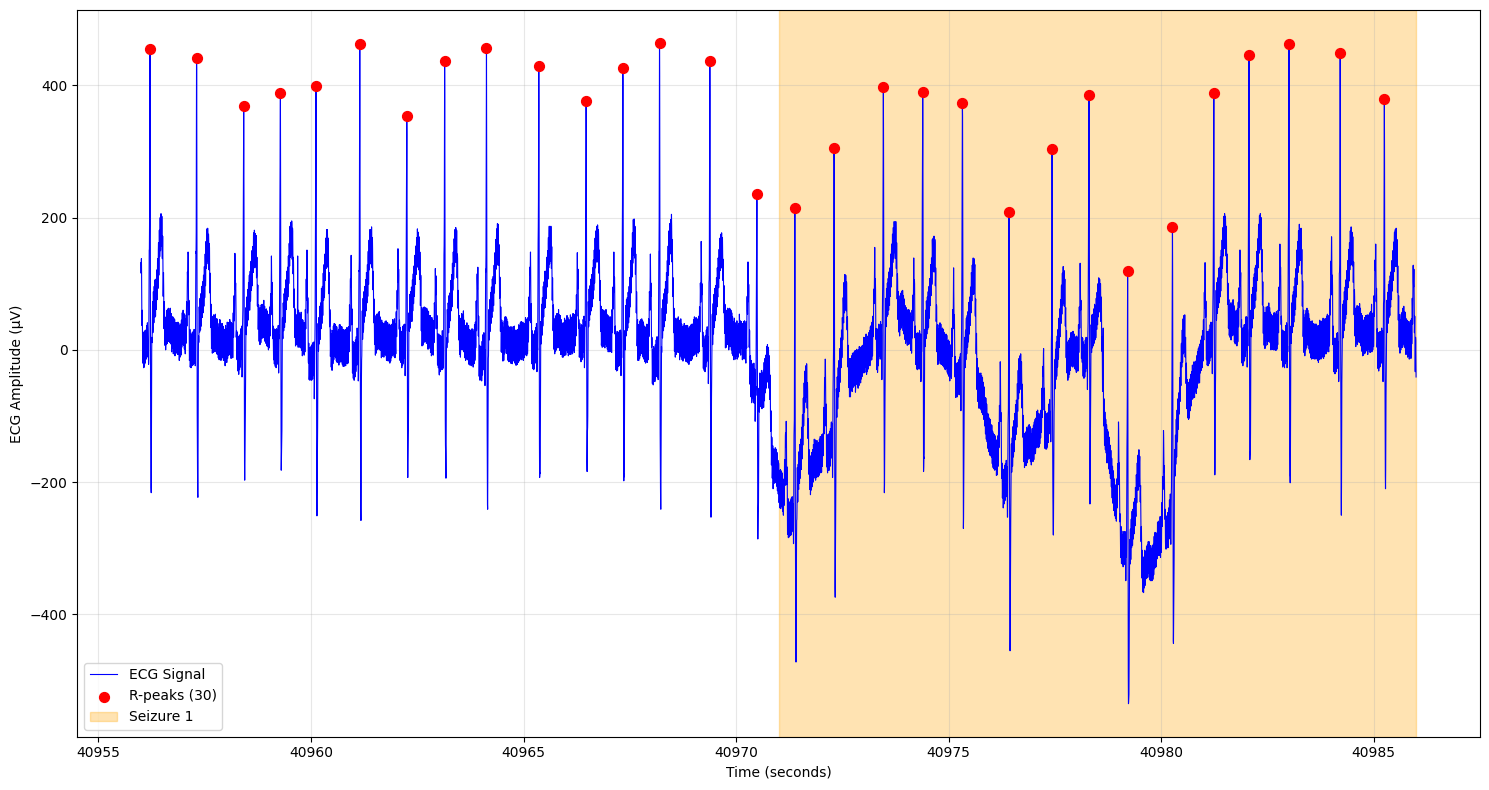

Statistics for this window:
  R-peaks detected: 30
  Average RR interval: 1001.3 ms
  Average heart rate in window: 59.9 bpm


In [109]:
plot_ecg_with_rpeaks(processed_data, time_window_seconds=3600, start_time=0)

# If there are seizure events, plot around the first seizure
if processed_data['sub-036'][0]['seizure_events']:
    first_seizure = processed_data['sub-036'][0]['seizure_events'][0]
    seizure_start = first_seizure['onset_time']
    
    print(f"\nPlotting around first seizure at {seizure_start:.1f}s:")
    # Plot 30 seconds starting 15 seconds before seizure
    plot_ecg_with_rpeaks(processed_data, time_window_seconds=30, start_time=max(0, seizure_start - 15))